In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
import numpy as np

df = pd.read_parquet('../data/rucphen_precipitation_clean.parquet')

In [39]:
def create_plot(df, x,xlabel, y, ylabel, title):
    # Create a line plot using seaborn
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x = x, y = y)

    # Set labels and title
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    # Display the plot
    plt.show()
def show_df(df, start = pd.to_datetime('2020-02-01 08:00:00'), end = pd.to_datetime('2023-11-01 08:00:00')):
    # Define the start and end timestamps
    start_timestamp = start
    end_timestamp = end

    # Create a boolean mask for the specified time range
    mask = (df['timestamp'] >= start_timestamp) & (df['timestamp'] < end_timestamp)

    # Apply the mask to get the desired slice of the DataFrame
    result_df = df[mask]

    create_plot(result_df, 'timestamp','Timestamp', 'precipitation','mm', 'Line Plot: Rainfall over time')
    create_plot(result_df, 'timestamp','Timestamp', 'percentage','%', 'Line Plot: Percentage full over time')


/home/stijn/miniconda3/envs/xgboost/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/stijn/miniconda3/envs/xgboost/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


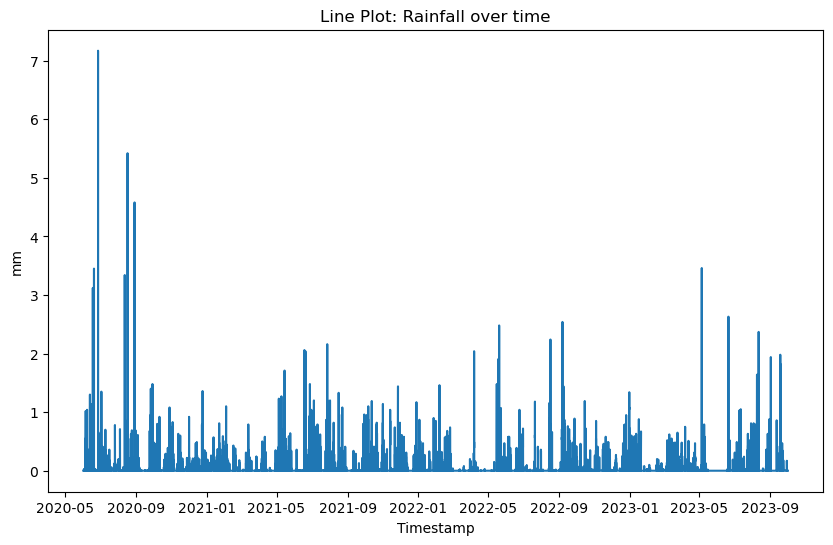

/home/stijn/miniconda3/envs/xgboost/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/stijn/miniconda3/envs/xgboost/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


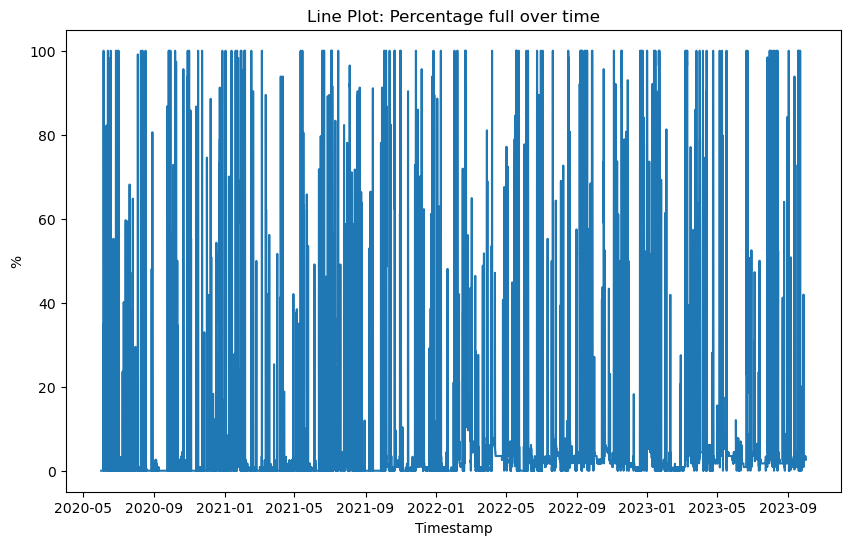

In [40]:
show_df(df, pd.to_datetime('2020-06-01 08:00:00'), pd.to_datetime('2023-10-01 08:00:00'))

/tmp/ipykernel_5311/4272615548.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced.fillna(0, inplace=True)
/home/stijn/miniconda3/envs/xgboost/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/stijn/miniconda3/envs/xgboost/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


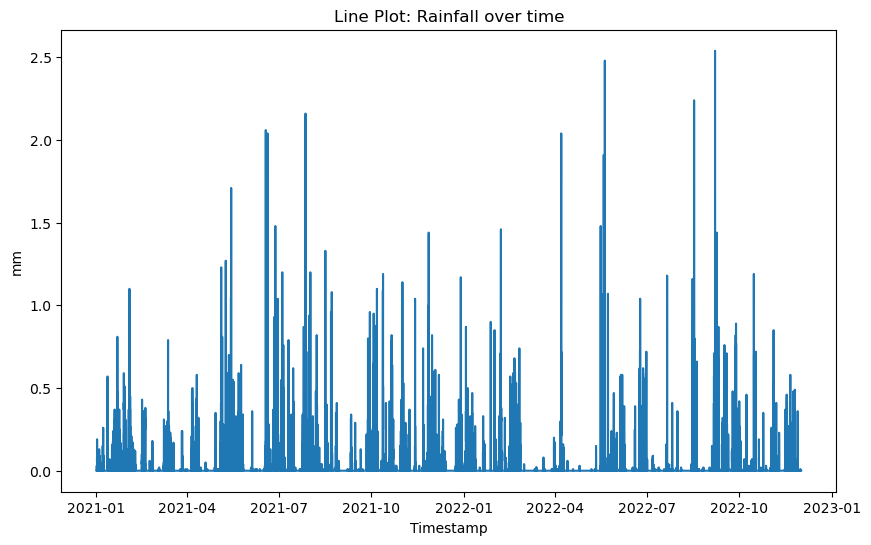

/home/stijn/miniconda3/envs/xgboost/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/stijn/miniconda3/envs/xgboost/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


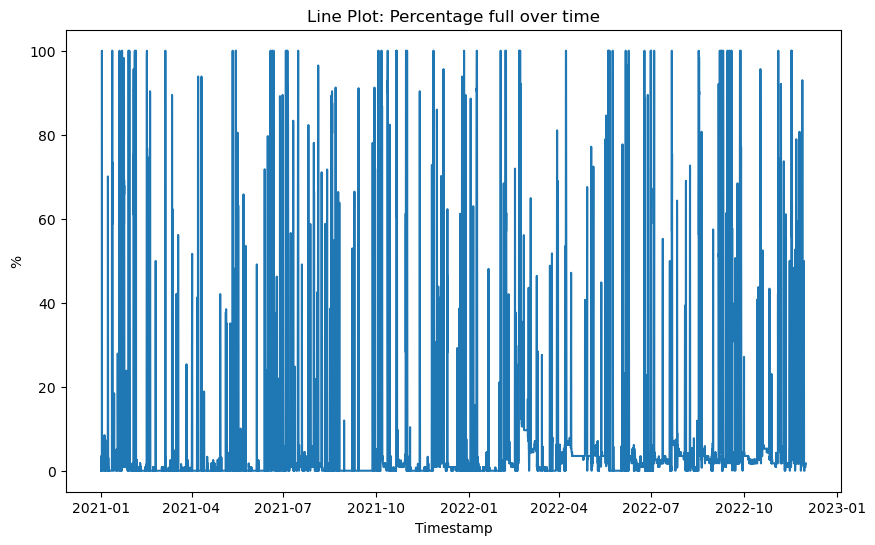

In [41]:
start_timestamp = pd.to_datetime('2022-01-01 08:00:00')
end_timestamp = pd.to_datetime('2022-12-01 08:00:00')

# Create a boolean mask for the specified time range
mask = (df['timestamp'] >= start_timestamp) & (df['timestamp'] < end_timestamp)

# Apply the mask to get the desired slice of the DataFrame
df_reduced = df[mask]
df_reduced.fillna(0, inplace=True)
show_df(df_reduced)

In [42]:
def df_features_of_df(df: pd.DataFrame):
    # Datetime features
    # Extracting features
    df_features = df.copy()
    # df_features['percentage_delta'] = df_features['percentage'].diff()
    # df_features['percentage_delta'].fillna(0, inplace=True)
    print(df_features)

    df_features['hour'] = df_features['timestamp'].dt.hour
    df_features['dayofweek'] = df_features['timestamp'].dt.hour
    df_features['month'] = df_features['timestamp'].dt.hour

    # Define the lags you want
    # precipitation_lags = [1, 2, 3, 4, 5, 6]
    # percentage_delta_lags = [1, 2, 3, 4]
    percentage_lags = [1, 2, 3, 4, 5, 6]

    # df_features['precipitation_0-30'] = df_features['precipitation'].rolling(6, min_periods=1).sum()
    df_features['precipitation_0-60'] = df_features['precipitation'].rolling(12, min_periods=1).sum()
    df_features['precipitation_60-120'] = df_features['precipitation'].shift(13).rolling(12, min_periods=1).sum()
    # df_features['precipitation_90-120'] = df_features['precipitation'].rolling(24, min_periods=1).sum()
    
    # df_features['percentage_0-30'] = df_features['precipitation'].rolling(6, min_periods=1).sum()
    df_features['percentage_30-60'] = df_features['percentage'].shift(7).rolling(6, min_periods=1).sum()
    df_features['percentage_60-90'] = df_features['percentage'].shift(13).rolling(6, min_periods=1).sum()
    # df_features['percentage_90-120'] = df_features['precipitation'].rolling(24, min_periods=1).sum()

    # df_features['precipitation_0-180'] = df_features['precipitation'].rolling(30, min_periods=1).sum()
    # df_features['precipitation_0-240'] = df_features['precipitation'].rolling(36, min_periods=1).sum()
    # df_features['percentage_0-30'] = df_features['percentage'].rolling(6, min_periods=1).sum()
    # df_features['percentage_delta_30-60'] = df_features['percentage_delta'].shift(5).rolling(8, min_periods=1).sum()
    # df_features['percentage_delta_60-90'] = df_features['percentage_delta'].shift(13).rolling(6, min_periods=1).sum()
    # df_features['percentage_delta_90-120'] = df_features['percentage_delta'].shift(19).rolling(6, min_periods=1).sum()

    # Add lag features for 'precipitation'
    # for lag in precipitation_lags:
    #     df_features[f'precipitation_lag_{lag}'] = df_features['precipitation'].shift(lag)

    # Add lag features for 'percentage_delta'
    # for lag in percentage_delta_lags:
    #     df_features[f'percentage_delta_lag_{lag}'] = df_features['percentage_delta'].shift(lag)

    # Add lag features for 'percentage'
    for lag in percentage_lags:
        df_features[f'percentage_lag_{lag}'] = df_features['percentage'].shift(lag)

    return df_features

In [43]:
df_features = df_features_of_df(df_reduced)
# Drop rows with NaN values introduced by the lag operation
df_features.dropna(inplace=True)

# Reset index to integers
df_features = df_features.reset_index(drop=True)
df_features.head()

                 timestamp  precipitation  percentage
208297 2021-01-01 08:00:00            0.0       0.000
208298 2021-01-01 08:05:00            0.0       0.000
208299 2021-01-01 08:10:00            0.0       0.000
208300 2021-01-01 08:15:00            0.0       0.000
208301 2021-01-01 08:20:00            0.0       0.000
...                    ...            ...         ...
409004 2022-12-01 07:35:00            0.0       1.754
409005 2022-12-01 07:40:00            0.0       1.754
409006 2022-12-01 07:45:00            0.0       1.754
409007 2022-12-01 07:50:00            0.0       1.754
409008 2022-12-01 07:55:00            0.0       1.754

[200712 rows x 3 columns]


,timestamp,precipitation,percentage,hour,dayofweek,month,precipitation_0-60,precipitation_60-120,percentage_30-60,percentage_60-90,percentage_lag_1,percentage_lag_2,percentage_lag_3,percentage_lag_4,percentage_lag_5,percentage_lag_6
0,2021-01-01 09:05:00,0.0,2.632,9,9,9,0.0,0.0,3.257,0.0,2.632,2.589,2.296,2.004,1.754,1.754
1,2021-01-01 09:10:00,0.0,2.632,9,9,9,0.0,0.0,5.011,0.0,2.632,2.632,2.589,2.296,2.004,1.754
2,2021-01-01 09:15:00,0.0,2.632,9,9,9,0.0,0.0,6.765,0.0,2.632,2.632,2.632,2.589,2.296,2.004
3,2021-01-01 09:20:00,0.0,2.632,9,9,9,0.0,0.0,8.769,0.0,2.632,2.632,2.632,2.632,2.589,2.296
4,2021-01-01 09:25:00,0.0,2.632,9,9,9,0.0,0.0,11.065,0.0,2.632,2.632,2.632,2.632,2.632,2.589


In [44]:
# Extract features and target from the DataFrame

X = df_features.copy()
# X.drop(columns=['timestamp', 'percentage', 'percentage_delta'], inplace=True)
# y = df_features['percentage_delta']

X.drop(columns=['timestamp', 'percentage'], inplace=True)
y = df_features['percentage']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y.to_numpy().reshape(-1, 1), test_size=0.5, shuffle=False)


# Standardize Data
# class MinMaxPositiveScaler:
#     def __init__(self):
#         self.min_max_scaler = MinMaxScaler()

#     def fit(self, X):
#         self.min_max_scaler.fit(X)
#         return self

#     def transform(self, X):
#         scaled_data = self.min_max_scaler.transform(X)
#         shifted_data = scaled_data + abs(np.min(scaled_data)) # Shift to make all numbers positive
#         return shifted_data
    
#     def inverse_transform(self, X):
#         scaled_data = self.min_max_scaler.inverse_transform(X)
#         shifted_data = scaled_data - abs(np.min(scaled_data))  # Shift numbers back
#         return shifted_data

#     def fit_transform(self, X):
#         self.fit(X)
#         return self.transform(X)

scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

def scale_X(df: pd.DataFrame):
    return scaler_X.transform(df)
def scale_y(df: pd.DataFrame):
    return scaler_y.transform(df)

In [45]:
print("Number of samples in X_train_scaled:", len(X_train_scaled))
print("Number of samples in y_train:", len(y_train_scaled))
print("Number of samples in X_test_scaled:", len(X_test_scaled))
print("Number of samples in y_test:", len(y_test_scaled))

y_train_scaled

Number of samples in X_train_scaled: 100349
Number of samples in y_train: 100349
Number of samples in X_test_scaled: 100350
Number of samples in y_test: 100350


array([[0.02632],
       [0.02632],
       [0.02632],
       ...,
       [0.     ],
       [0.     ],
       [0.     ]])

In [46]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
import xgboost as xgb
from joblib import dump, load

train = True

if train:
    # Train XGBoost Model
    model = xgb.XGBRegressor()

    # Assuming X_train_scaled, y_train are already defined

    # https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning
    # We have 2 types of boosters - tree booster and linear booster.
    param_grid = {
        # Can also use gblinear for lineair model

        # gbtree and dart - use tree-based models, while
        # gblinear uses linear models. 'We will limit our discussion to tree booster because it always outperforms the linear booster and thus the later is rarely used.'
        'booster': ['gbtree', 'dart'], 
        # Typical final values : 0.01-0.2.
        'learning_rate': [0.01, 0.1, 0.2],
        'n_estimators': [50, 100, 200],
        # Typical values: 3-10. Trying higher values as the Random Forest model works best at 14
        'max_depth': [3, 5, 9, 13, 15, 17],
        # Range: [0,∞]. 'Practically, the limit for gamma is around 20 and extremely rare (Laurae, 2016).'
        'gamma': [0, 0.1, 0.5, 1, 2, 6, 15, 20],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        # range: [0,∞]
        'min_child_weight': [1]
    }

    # Define scoring using multiple metrics
    scoring = {'MSE': make_scorer(mean_squared_error, greater_is_better=False),
               'R2': make_scorer(r2_score)}

    # TimeSeriesSplit with 5 splits
    tscv = TimeSeriesSplit(n_splits=5)

    grid_search = GridSearchCV(model, param_grid, cv=tscv, scoring=scoring, refit='R2', n_jobs=-1)

    grid_search.fit(X_train_scaled, y_train_scaled.ravel())

    # Save the model
    dump(grid_search, 'xgboost.joblib')

else:
    grid_search = load('xgboost.joblib')


KeyboardInterrupt: 

In [ ]:
import pickle

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(best_params)
print(best_model)


{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)


Mean Squared Error: 0.05605722194980116
r2: -0.17068195730976932


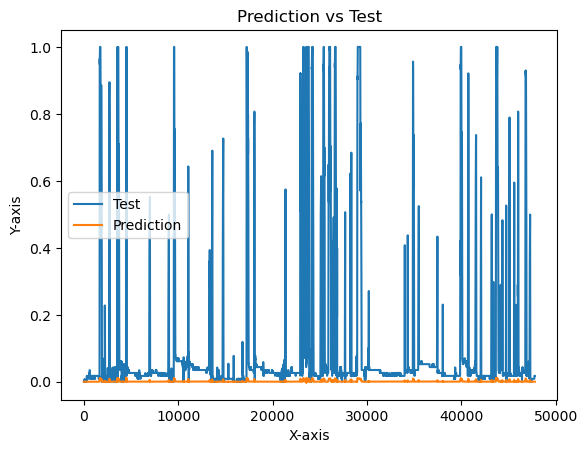

In [ ]:
def predict(X_test_scaled, model):
    # Make Predictions
    return scale_y(best_model.predict(X_test_scaled).reshape(-1, 1))

def evaluate(y_test, predictions):

    # # Use np.clip to limit values between 0 and 100
    # predictions_clipped = np.clip(predictions, 0, 100)

    # Evaluate the Model
    mse = mean_squared_error(y_test, predictions)
    print(f'Mean Squared Error: {mse.item()}')

    r2 = r2_score(y_test, predictions)
    print(f'r2: {r2.item()}')

    # Plotting
    plt.plot(y_test, label='Test')
    plt.plot(predictions, label='Prediction')

    # Adding labels and title
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Prediction vs Test')

    # Adding legend
    plt.legend()

    # Display the plot
    plt.show()

def predict_and_evaluate(X_test_scaled, y_test, model):
    predictions = predict(X_test_scaled, model)
    evaluate(y_test, predictions)

predict_and_evaluate(X_test_scaled, y_test_scaled, best_model)

                 Feature  Importance
0       percentage_lag_1    0.987644
1       percentage_lag_5    0.002145
2       percentage_lag_2    0.001586
3       percentage_lag_3    0.001462
4       percentage_lag_6    0.001376
5       percentage_lag_4    0.001244
6   precipitation_90-120    0.001202
7    precipitation_60-90    0.000927
8    precipitation_lag_4    0.000714
9    precipitation_lag_2    0.000331
10   precipitation_lag_3    0.000270
11   precipitation_lag_6    0.000251
12   precipitation_30-60    0.000246
13   precipitation_lag_1    0.000190
14                  hour    0.000179
15   precipitation_lag_5    0.000121
16         precipitation    0.000113
17      percentage_30-60    0.000000
18      percentage_60-90    0.000000
19     percentage_90-120    0.000000


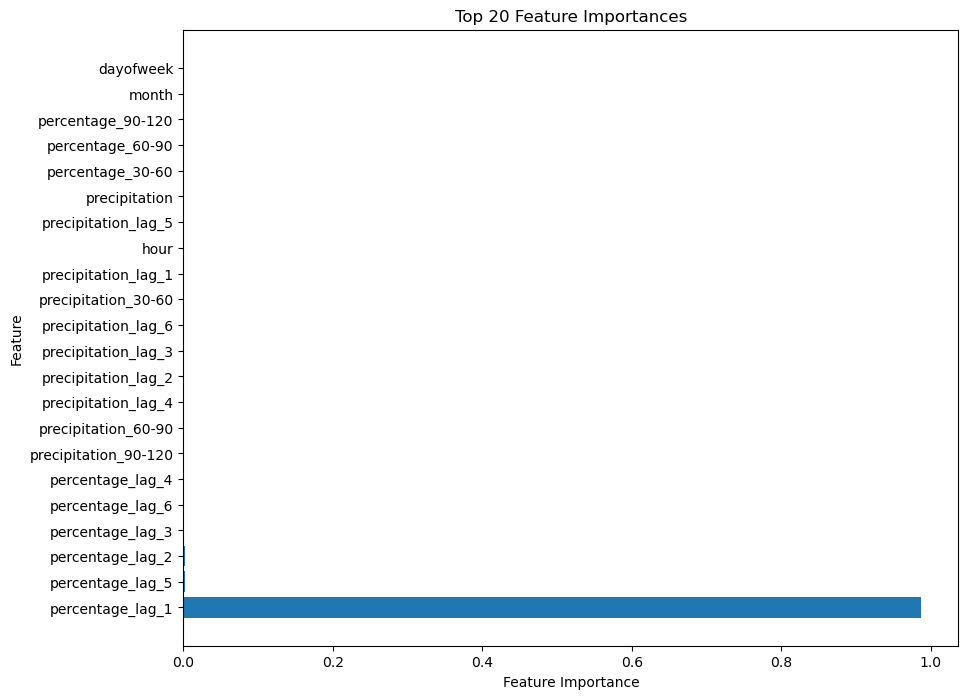

In [ ]:
from matplotlib import pyplot as plt

def plot_importances(model, feature_names):
    # Get feature importances from the model
    importances = model.feature_importances_

    # Sort indices and feature names
    indices = np.argsort(importances)[::-1]
    feature_names = [feature_names[i] for i in indices]

    # Create a DataFrame for better visualization
    df_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances[indices]})

    # Display the top 20 features
    print(df_importances.head(20))

    # Create a horizontal bar plot
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(feature_names)), importances[indices], align='center')

    # Set y-axis labels
    plt.yticks(range(len(feature_names)), feature_names)

    # Display the plot
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Top 20 Feature Importances')
    plt.show()

# Assuming best_model is your trained XGBoost model and X is your feature matrix
plot_importances(best_model, X.columns.tolist())


In [ ]:
from datetime import timedelta
def predict_one_step(X_test:pd.DataFrame, X_weather:pd.DataFrame):
    # X_test_filtered = X_test.drop(columns=['percentage_delta', 'percentage', 'timestamp'])
    X_test_filtered = X_test.drop(columns=['percentage', 'timestamp'])
    X_test_scaled = scale_X(X_test_filtered.tail(1))
    input = X_test.tail(1)

    percentage_delta = scale_y(predict(X_test_scaled, best_model)[0].reshape(-1, 1))

    # print('here', percentage_delta_clipped)

    future_timestamp = input['timestamp'].values[0] + + np.timedelta64(5, 'm')
    precipitation_row = X_weather[future_timestamp == X_weather['timestamp']].iloc[0]

    new_row = {
        'timestamp':future_timestamp,
        'precipitation': precipitation_row['precipitation'],
        # 'percentage_delta': percentage_delta,
        # 'percentage': input['percentage'].values[0] + percentage_delta
        'percentage': input['percentage'].values[0]
        }
    # df_unprocessed = pd.concat([X_test[['timestamp', 'percentage', 'percentage_delta', 'precipitation' ]], pd.DataFrame([new_row])], ignore_index=True)
    df_unprocessed = pd.concat([X_test[['timestamp', 'percentage', 'precipitation' ]], pd.DataFrame([new_row])], ignore_index=True)
    return df_features_of_df(df_unprocessed)
    
X_original = df_features_of_df(df_reduced)
first_nan_index = X_original['precipitation_0-240'].notna().idxmax()
X_result = X_original.copy()
X_result = X_result[X_result.index <= first_nan_index]
for i in range(0,int(len(X_original)/50)):
    X_result = predict_one_step(X_result,X_original)


# X_result[['percentage_delta', 'precipitation']].plot()
X_result[['percentage', 'precipitation']].plot()
X_result

                 timestamp  precipitation  percentage  percentage_delta
313409 2022-01-01 08:00:00            0.0       0.000               0.0
313410 2022-01-01 08:05:00            0.0       0.000               0.0
313411 2022-01-01 08:10:00            0.0       0.000               0.0
313412 2022-01-01 08:15:00            0.0       0.000               0.0
313413 2022-01-01 08:20:00            0.0       0.000               0.0
...                    ...            ...         ...               ...
409004 2022-12-01 07:35:00            0.0       1.754               0.0
409005 2022-12-01 07:40:00            0.0       1.754               0.0
409006 2022-12-01 07:45:00            0.0       1.754               0.0
409007 2022-12-01 07:50:00            0.0       1.754               0.0
409008 2022-12-01 07:55:00            0.0       1.754               0.0

[95600 rows x 4 columns]
            timestamp              percentage        percentage_delta  \
0 2022-01-01 08:00:00                

KeyboardInterrupt: 